# GPT-4o Based Rehab Exercise Evaluation

Based on https://github.com/openai/openai-cookbook/blob/main/examples/gpt4o/introduction_to_gpt4o.ipynb

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from constants import *
from pathlib import Path

import cv2
import json
import time
import base64
import pickle as pkl
from tqdm import tqdm
from glob import glob
from IPython.display import Image, display, Markdown

In [ ]:
!pip install --upgrade openai
!pip install --upgrade ollama

## Combine Tables to Obtain Trimmed Video Clips for each Repetition

Organize File Directories

In [97]:
vid2stamp = pd.read_csv('./kimore_annotations_all_exercises.csv')
id2vid = pd.read_csv('./video_person_exercise_mapping.csv')

In [98]:
id2vid.head()

,PersonID,ExerciseNum,AnnotationVideoNum
0,E_ID12,0,V1
1,P_ID11,0,V10
2,NE_ID19,0,V11
3,NE_ID14,0,V12
4,B_ID1,0,V13


In [99]:
vid2stamp.head()

,Exercise,Video,Repetition,Start,End,Incomplete
0,Exercise_0,V1,1,0:00:00.94,0:00:05.22,0
1,Exercise_0,V1,2,0:00:05.22,0:00:10.58,0
2,Exercise_0,V1,3,0:00:10.58,0:00:15.90,0
3,Exercise_0,V1,4,0:00:15.90,0:00:20.70,0
4,Exercise_0,V1,5,0:00:20.70,0:00:25.58,0


In [100]:
id2vid['exe_vid'] = id2vid['ExerciseNum'].astype(str) + id2vid['AnnotationVideoNum']
vid2stamp['Exercise'] = vid2stamp['Exercise'].str.replace('Exercise_', '')
vid2stamp['exe_vid'] = vid2stamp['Exercise'] + vid2stamp['Video']

In [101]:
id2stamp = vid2stamp.join(id2vid.set_index('exe_vid'), on='exe_vid', how='left').drop(columns=['AnnotationVideoNum', 'Video', 'Incomplete', 'ExerciseNum', 'exe_vid'])

In [102]:
id2stamp.to_csv('./id2stamp.csv', index=False)

In [103]:
id2stamp = pd.read_csv('./id2stamp.csv')

In [104]:
# Constructing a filename
id2stamp['Exercise_1start'] = id2stamp['Exercise'].astype(int) +1
id2stamp['person_ex'] = id2stamp['PersonID'].astype(str) + "_Es" + id2stamp['Exercise_1start'].astype(str) 
# id2stamp['fname'] = id2stamp['PersonID'].astype(str) + "_Es" + id2stamp['Exercise'].astype(str) + "_" + id2stamp['Repetition'].astype(str)

In [105]:
id2stamp.head()

,Exercise,Repetition,Start,End,PersonID,Exercise_1start,person_ex
0,0,1,0:00:00.94,0:00:05.22,E_ID12,1,E_ID12_Es1
1,0,2,0:00:05.22,0:00:10.58,E_ID12,1,E_ID12_Es1
2,0,3,0:00:10.58,0:00:15.90,E_ID12,1,E_ID12_Es1
3,0,4,0:00:15.90,0:00:20.70,E_ID12,1,E_ID12_Es1
4,0,5,0:00:20.70,0:00:25.58,E_ID12,1,E_ID12_Es1


In [106]:
float(id2stamp['Start'][0].replace('0:00:', ''))

0.94

Video Processing Funcs

In [109]:
def timestamp_to_seconds(timestamp):
    hours, minutes, seconds = map(float, timestamp.split(':'))
    total_seconds = hours*3600 + minutes * 60 + seconds
    return float(total_seconds)

def process_video(video_path, frames_to_skip=2):
    """Modified from https://github.com/openai/openai-cookbook/blob/main/examples/gpt4o/introduction_to_gpt4o.ipynb"""
    frames, base64Frames, frame_nums = [], [], []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        
        if not success:
            break
        # Resize frame to 224 pixels vertically
        frame = cv2.resize(frame, (int(frame.shape[1] * (224 / frame.shape[0])), 224))
        
        # Crop the middle 224 pixels horizontally
        start_x = int((frame.shape[1] - 224) / 2)
        frame = frame[:, start_x:start_x + 224]
    
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        frames.append(frame)
        frame_nums.append(curr_frame)

        curr_frame += frames_to_skip

    return frames, base64Frames, frame_nums

In [323]:
id2stamp[id2stamp['person_ex'] == 'E_ID6_Es2']

,Exercise,Repetition,Start,End,PersonID,fname,person_ex,Repetition_1start,Exercise_1start
497,1,1,0:00:01.14,0:00:05.56,E_ID6,E_ID6_Es1_1,E_ID6_Es2,2,2
498,1,2,0:00:05.56,0:00:09.18,E_ID6,E_ID6_Es1_2,E_ID6_Es2,3,2
499,1,3,0:00:09.18,0:00:12.85,E_ID6,E_ID6_Es1_3,E_ID6_Es2,4,2
500,1,4,0:00:12.85,0:00:16.64,E_ID6,E_ID6_Es1_4,E_ID6_Es2,5,2
501,1,5,0:00:16.64,0:00:20.31,E_ID6,E_ID6_Es1_5,E_ID6_Es2,6,2


In [ ]:
def threaded(fn):
    def wrapper(*args, **kwargs):
        thread = threading.Thread(target=fn, args=args, kwargs=kwargs)
        thread.start()
        return thread
    return wrapper

class MyClass:
    somevar = 'someval'

    @threaded
    def func_to_be_threaded(self):
        print 'xyz'

In [545]:
def extract_video_from_df(vidfname, id2stamp):
    fname = vidfname.split('/')[2] + "_" + vidfname.split('/')[3]

    rows = id2stamp[id2stamp['person_ex'] == fname]

    if rows.empty:
        return

    frames, base64_frames, frame_count = process_video(vidfname, frames_to_skip=2)

    # for each row/repetition, extract and save the relevant frames
    for _, rep_row in rows.iterrows():
        t_start = timestamp_to_seconds(rep_row['Start'])
        t_end = timestamp_to_seconds(rep_row['End'])
        names = glob(f"./store/{rep_row['PersonID']}_Es{int(rep_row['Exercise'])+1}_{int(rep_row['Repetition'])-1}_s=*")
                     
        if not names:
            # print(f"./store/{rep_row['PersonID']}_Es{int(rep_row['Exercise'])+1}_{int(rep_row['Repetition'])-1}_s=*")
            continue
        name = names[0]

        base64_filename = f"{name}/base64.txt"
        base64_framegroup = []

        for idx, frame_num in enumerate(frame_count):
            if frame_num >= 25*t_start and frame_num <= 25*t_end:
                base64_framegroup.append(base64_frames[idx])

        with open(base64_filename, "w") as f:
            f.seek(0)
            f.truncate()
            for base64Frame in base64_framegroup:
                f.write(base64Frame + "\n")

Video Extraction and saving to base64 strings

In [546]:
vidfnames = glob(f"./rgb/*_ID*/Es*/rgb/*.mp4")

# for each video, get the corresponding rows in id2stamp
for idx, vidfname in enumerate(tqdm(vidfnames)):
    extract_video_from_df(vidfname, id2stamp)

  0%|          | 0/353 [00:00<?, ?it/s]

100%|██████████| 353/353 [1:18:58<00:00, 13.42s/it]


In [ ]:
# This is used for extracting the frames based on the folds - Deprecated

for fold in range(0, 10):
    with open(f"./LMSO_10/skelton_3D_LMSO_{fold}.pkl", "rb") as f:
        object = pkl.load(f)

    for idx, val in enumerate(tqdm(list(object.values())[1])):
        score = str(int(val['label'][0]))

        name = f"{val['frame_dir']}_s={score}"
        if not os.path.isdir(f'./store/{name}'):
            os.mkdir(f'./store/{name}')
        rep_row = id2stamp[id2stamp['fname'] == val['frame_dir']]

        if rep_row.empty:
            continue

        rep_row = rep_row.iloc[0]

        person_id = rep_row['PersonID']
        exe_id = int(rep_row['Exercise'])

        # get the video file
        vidfnames = glob(f"./rgb/{person_id}/Es{exe_id+1}/rgb/*.mp4")
        if not vidfnames:
            print("Empty video dir")
            continue

Import base64 video Ground Truths 

In [2]:
exercise_num = [1, 2, 3, 4, 5]
score_num = [0, 1, 2, 3]

In [10]:
# build Label dict containing gound truths
dir_labels_gt = {}
exe_labels_gt = {}

for exe in exercise_num:
    dir_labels_gt[exe] = {}
    exe_labels_gt[exe] = {}
    for score in score_num:
        dirs = glob(f"./store/*E_ID*_Es{exe}_*_s={score}")
        if dirs:
            for dir in dirs:
                # Find the first dir that has a base64.txt file
                if os.path.isfile(f"{dir}/base64.txt"):
                    with open(f"{dir}/base64.txt", "r") as f:
                        b64_frames = f.readlines()
                        if len(b64_frames) == 0:
                            continue
                        img_indices = np.linspace(2, len(b64_frames)-2, 5, dtype=int).tolist()
                        exe_labels_gt[exe][score] = [b64_frames[idx] for idx in img_indices]
                        dir_labels_gt[exe][score] = dir
                    break
        else: # need to re-search ground truth in something that is not Expert/NonExpert
            dirs = glob(f"./store/*_ID*_Es{exe}_*_s={score}")
            for dir in dirs:
                # Find the first dir that has a base64.txt file
                if os.path.isfile(f"{dir}/base64.txt"):
                    with open(f"{dir}/base64.txt", "r") as f:
                        b64_frames = f.readlines()
                        if len(b64_frames) == 0:
                            continue
                        img_indices = np.linspace(2, len(b64_frames)-2, 5, dtype=int).tolist()
                        exe_labels_gt[exe][score] = [b64_frames[idx] for idx in img_indices]
                        dir_labels_gt[exe][score] = dir
                    break
b64_frames = None

In [572]:
# Create an empty DataFrame
all_reps_df = pd.DataFrame(columns=['pid', 'exe_num', 'score', 'dir'])

# Iterate over the dir_labels_gt dictionary
for exe_num in range(1,6):
    for score_num in range(0,4):
        file_paths = glob(f'./store/*_Es{exe_num}_*_s={score_num}/base64.txt')
        # print(f'./store/*_Es{exe_num}_*_s={score_num}/base64.txt', len(file_paths))
        # Get the patient ID and score number from the directory path
        for file_path in file_paths:
            fname = file_path.split('/')[-2]
            pid = fname.split('_')[0] + '_' + fname.split('_')[1]
            # Append the data to the DataFrame
            all_reps_df = all_reps_df.append(
                {'pid': pid, 'exe_num': int(exe_num), 'score': int(score_num),
                            'dir': file_path,},
                ignore_index=True
            )


In [41]:
# all_reps_df.to_csv('./all_reps_df.csv', index=False)
all_reps_df = pd.read_csv('./all_reps_df_w_q.csv')

## OAI and Ollama Inference Funcs

Initialize OAI Client

In [425]:
import openai

openai.api_key = oai_key
openai.default_headers = {"OpenAI-Beta": "assistants=v2"}

response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
    {"role": "system", "content": "You are generating a video summary. What is in this video? Respond in Markdown."},
    ]
)

print(response)

ChatCompletion(id='chatcmpl-9Y0I7Pc009ttMv6CUpfxKfLUrT9Iy', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='# Video Summary\n\n## Title\n**"The Secret Behind a Successful Morning Routine"**\n\n## Presenter\n*Ella Smith*\n\n## Duration\n*10:15 minutes*\n\n## Content Overview\n\n### Introduction (0:00 - 1:00)\n- Ella Smith welcomes viewers and introduces the topic of optimizing morning routines for a successful day.\n- Brief mention of the benefits of having a structured morning routine.\n\n### The Importance of a Morning Routine (1:01 - 2:30)\n- Explanation of how a consistent morning routine can improve productivity, mental health, and overall well-being.\n- Mention of scientific studies supporting the importance of starting the day with intention.\n\n### Key Components of a Successful Morning Routine (2:31 - 7:30)\n1. **Wake Up Early** (2:31 - 3:30)\n   - Importance of waking up at the same time every day.\n   - Tips for adjusting t

In [3]:
def clean_json_string(json_string):
    pattern = r'^```json\s*(.*?)\s*```$'
    cleaned_string = re.sub(pattern, r'\1', json_string, flags=re.DOTALL)
    return cleaned_string.strip()

### OAI Inference Funcs and Defs

In [4]:
MODEL="gpt-4o"
client = OpenAI(api_key=oai_key)

In [447]:
# get the exercise description
struc_desc_by_exe = {}
for exe_num in exercise_num:
    with open(f"./struc_data/exec_descs/exec_{exe_num}_desc_nat.md") as f:
        exec_desc = f.read()
        struc_desc_by_exe[exe_num] = exec_desc

# get background description, user intro, answer format, and system intro
intro_sys, intro_user, background_text, struc_desc_text, rep_eval, ans_format = None, None, None, None, None, None
with open("./struc_data/background_desc/intro_system_video.md") as f:
	intro_sys = f.read()
with open("./struc_data/background_desc/intro_user_video.md") as f:
	intro_user = f.read()
with open("./struc_data/background_desc/backgrounds_videos.md") as f:
	background_text = f.read()
with open("./struc_data/task_descs/rep_eval.md") as f:
	rep_eval = f.read()
with open("./struc_data/ans_format/ans_format.json") as f:
	ans_format = json.dumps(json.load(f))

rep_eval_10q, assess_q, ans_format_0s = None, None, None
with open("./struc_data/background_desc/backgrounds_10q_0s.md") as f:
	background_10q_0s = f.read()
with open("./struc_data/task_descs/rep_eval_10q.md") as f:
	rep_eval_10q = f.read()
with open("./struc_data/que_format/assess_q.json") as f:
	assess_q = json.dumps(json.load(f))
with open("./struc_data/ans_format/ans_format_0s.json") as f:
	ans_format_0s = json.dumps(json.load(f))

In [99]:
def get_gt_b64_from_exe_n_dict(exe_n_labels_gt, detail="low"):
    """wrap Ground truth in base64"""
    gt_exe_b64 = []

    for score in range(0,4):
        gt_exe_b64.append({"type": "text", "text":
            f"BEGINS 5 frames containing the ground truth for this exercise marked with score {score}"})
        seq = map(lambda x: {"type": "image_url",
                            "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": detail}}, exe_n_labels_gt[score])
        gt_exe_b64.extend([*seq])
    gt_exe_b64.append({"type": "text", "text": f"ENDS ground truth sequence"})
    return gt_exe_b64

gt_exe_b64 = get_gt_b64_from_exe_n_dict(exe_labels_gt[2], detail="low")

In [246]:
def get_eval_b64_from_dir(dir_path, detail="low", num_frames=5):
    """Obtaining the evaluation sequence and assemble the b64 array"""
    base64_frames = None
    with open(dir_path) as f:
        base64_frames = f.readlines()
        if len(base64_frames) == 0:
            return -1
        img_indices = np.linspace(1, len(base64_frames)-1, num_frames, dtype=int).tolist()
        eval_label = [base64_frames[idx] for idx in img_indices]

    eval_b64 = []
    eval_b64.append({"type": "text", "text":
        f"BEGINS with 5 frames containing the evaluation label for this exercise."})
    seq_e = map(lambda x: {"type": "image_url",
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": detail}}, eval_label)
    eval_b64.extend([*seq_e])
    eval_b64.append({"type": "text", "text": f"ENDS with evaluation sequence"})
    return eval_b64

# Obtain one evaluation dataset
# eval_dir = all_reps_df[(all_reps_df['score'] == 3) & (all_reps_df['exe_num'] == 2)]['dir'].iloc[0]
eval_b64 = get_eval_b64_from_dir('./store/NE_ID19_Es2_2_s=3/base64.txt')

In [767]:
def eval_with_oai(intro_sys, intro_user, background_text, struc_desc_text,
                  rep_eval, gt_exe_b64, eval_b64, ans_format,
                max_tokens=100):
    """Inference Function"""
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": intro_sys},
            {"role": "user", "content": intro_user},
            {"role": "assistant", "content": "Of course! Please assign me with a task."},
            {"role": "user", "content": rep_eval},
            {"role": "assistant", "content": "May I have some background information on the image sequences?"},
            {"role": "user", "content": background_text},
            {"role": "assistant", "content": "Alright. To start off, please provide me with the exercise description."},
            {"role": "user", "content": struc_desc_text},
            {"role": "assistant", "content": "Next, please provide me with the ground truth sequences."},
            {"role": "user", "content": gt_exe_b64},
            {"role": "assistant", "content": "Please provide the sequence you wish to evaluate so I can assign a score."},
            {"role": "user", "content": eval_b64},
            {"role": "assistant", "content": "Lastly, please provide the answer sheet."},
            {"role": "user", "content": ans_format},
        ],
        temperature=.5,
        max_tokens=max_tokens,
        # stream=True,
    )
    return response

response = eval_with_oai(intro_sys, intro_user, background_text, struc_desc_by_exe[2],
                         rep_eval, gt_exe_b64, eval_b64, ans_format)
print(json.loads(clean_json_string(response.choices[0].message.content)))
# for chunk in response:
#   print(chunk.choices[0].delta.content, end='', flush=True)

{'reasoning': 'The evaluated sequence shows the subject maintaining proper posture, extension angles, and distances similar to the ground truth sequence with score 3, but with slight deviations in trunk tilt angles.', 'score': 2}


In [55]:
def eval_with_oai_10q(intro_sys, intro_user, background_text, struc_desc_text,
                  rep_eval_10q, assess_q, eval_b64, ans_format_0s,
                max_tokens=200):
    """Inference Function"""
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": intro_sys},
            {"role": "user", "content": intro_user},
            {"role": "assistant", "content": "Of course! Please assign me with a task."},
            {"role": "user", "content": rep_eval_10q},
            {"role": "assistant", "content": "May I have some background information on the image sequences?"},
            {"role": "user", "content": background_text},
            {"role": "assistant", "content": "Alright. To start off, please provide me with the exercise description."},
            {"role": "user", "content": struc_desc_text},

            {"role": "assistant", "content": "Next, please provide me with the QS questionnares."},
            {"role": "user", "content": assess_q},

            {"role": "assistant", "content": "Please provide the sequence you wish to evaluate so I can assign a score."},
            {"role": "user", "content": eval_b64},
            {"role": "assistant", "content": "Lastly, please provide the answer sheet."},
            {"role": "user", "content": ans_format_0s},
            {"role": "user", "content": "Remember to provide answer in a single JSON object only"},
        ],
        temperature=.5,
        max_tokens=max_tokens,
        # stream=True,
    )
    return response

response = eval_with_oai_10q(intro_sys, intro_user, background_text, struc_desc_by_exe[2],
                         rep_eval_10q, assess_q, eval_b64, ans_format_0s)
print(json.loads(clean_json_string(response.choices[0].message.content)))
# for chunk in response:
#   print(chunk.choices[0].delta.content, end='', flush=True)

### Ollama Inference Funcs and Defs

In [697]:
from ollama import Client
client_ollama = Client(host='http://localhost:11434')

In [754]:
def get_gt_b64_from_exe_n_dict_ollama(exe_n_labels_gt):
    """wrap Ground truth in base64"""
    
    gt_exe_txt, gt_exe_b64 = [], []

    for score in range(0,4):
        gt_exe_txt.append(f"Here are 5 frames containing the ground truth for this exercise marked with score {score}")
        a = [str(frame) for frame in exe_n_labels_gt[score]]
        gt_exe_b64.append(a)

    return (gt_exe_txt, gt_exe_b64)

gt_exe_txt_b64 = get_gt_b64_from_exe_n_dict_ollama(exe_labels_gt[2])

In [762]:
def get_eval_b64_from_dir_ollama(dir_path):
    """Obtaining the evaluation sequence and assemble the b64 array"""
    base64_frames = None
    with open(dir_path) as f:
        base64_frames = f.readlines()
        if len(base64_frames) == 0:
            return -1
        img_indices = np.linspace(1, len(base64_frames)-1, 5, dtype=int).tolist()
        eval_label = [base64_frames[idx] for idx in img_indices]

    eval_txt = f"Here are with 5 frames containing the evaluation label for this exercise."
    return (eval_txt, eval_label)

# Obtain one evaluation dataset
eval_dir = all_reps_df[(all_reps_df['score'] == 3) & (all_reps_df['exe_num'] == 2)]['dir'].iloc[0]
eval_txt_b64 = get_eval_b64_from_dir_ollama('./store/NE_ID19_Es2_2_s=3/base64.txt')

In [ ]:
def eval_with_ollama(intro_sys, intro_user, background_text, struc_desc_text,
                  rep_eval, gt_txt_b64, eval_txt_b64, ans_format,
                model_name="llava:34b"):
    """Inference Function"""

    gt_txt, gt_b64 = gt_txt_b64
    eval_txt, eval_b64 = eval_txt_b64

    response = client_ollama.chat(
        model=model_name,
        messages=[
            {"role": "system", "content": intro_sys},
            {"role": "user", "content": intro_user},
            {"role": "assistant", "content": "Of course! Please assign me with a task."},
            {"role": "user", "content": rep_eval},
            {"role": "assistant", "content": "May I have some background information on the image sequences?"},
            {"role": "user", "content": background_text},
            {"role": "assistant", "content": "Alright. To start off, please provide me with the exercise description."},
            {"role": "user", "content": struc_desc_text},

            {"role": "assistant", "content": "Next, please provide me with the ground truth sequences."},
            {"role": "user", "content": gt_txt[0], "images": gt_b64[0]},
            {"role": "user", "content": gt_txt[1], "images": gt_b64[1]},
            {"role": "user", "content": gt_txt[2], "images": gt_b64[2]},
            {"role": "user", "content": gt_txt[3], "images": gt_b64[3]},

            {"role": "assistant", "content": "Please provide the sequence you wish to evaluate so I can assign a score."},
            {"role": "user", "content": eval_txt, "images": eval_b64},

            {"role": "assistant", "content": "Lastly, please provide the answer sheet."},
            {"role": "user", "content": ans_format},
        ],
        # stream=True,
        keep_alive=True
    )

    return response

response = eval_with_ollama(intro_sys, intro_user, background_text, struc_desc_by_exe[2],
                         rep_eval, gt_exe_txt_b64, eval_txt_b64, ans_format)
print(json.loads(clean_json_string(response.message.content)))
# for chunk in response:
#   print(chunk.choices[0].delta.content, end='', flush=True)

In [750]:
response

{'model': 'llava:34b',
 'created_at': '2024-06-14T03:26:19.028584296Z',
 'message': {'role': 'assistant',
  'content': 'Sure! Here\'s the JSON object for the given exercise description and sequence:\n```json\n{\n  "exercise_7": {\n    "name": "Lateral tilt of the trunk with the arms in extension",\n    "description": [\n      "The subject has to raise his/her arms above the head with the elbows completely extended and holding a bar with both hands (starting position).",\n      "The subject then has to tilt the trunk slowly first to the left and then to the right, keeping it exactly on the frontal plane.",\n      "After each tilt, the subject returns to the starting position."\n    ],\n    "requirements": [\n      "The movement must be performed so as to avoid bending the trunk backwards or forwards. The feet must always be on the ground, slightly apart, with the knees slightly flexed."\n    ],\n    "maximize": [\n      "Maximize the Left and Right angles between imaginary lines formed 

### Preparation for Batch Inference: Data Table Creation

In [ ]:
# Create a smaller eval set of 100 samples, add columns for inference score and reasoning
reps_df_100 = pd.DataFrame(columns=['pid', 'exe_num', 'score_gt', 'dir', 'score_q_total', 'score_q_po', 'score_q_cf',
                                     'score_inf_total', 'score_inf_po', 'score_inf_cf','inf_reasoning'])

for exe_num in exercise_num:
    for sc_num in score_num:
        df_row = all_reps_df[(all_reps_df['score'] == sc_num) & (all_reps_df['exe_num'] == exe_num)]
        df_row.rename(columns={'score': 'score_gt'}, inplace=True)
        reps_df_100 = pd.concat([reps_df_100, df_row.iloc[::df_row.shape[0]//5][:5]], ignore_index=True)

In [19]:
# reps_df_100.to_csv('./reps_df_100.csv', index=False)
reps_df_100 = pd.read_csv('./reps_df_100.csv')

In [20]:
reps_df_100

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,inf_reasoning
0,B_ID3,1,0,./store/B_ID3_Es1_0_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,NaN
1,S_ID9,1,0,./store/S_ID9_Es1_2_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,NaN
2,P_ID15,1,0,./store/P_ID15_Es1_2_s=0/base64.txt,27.666667,9.000000,18.666667,NaN,NaN,NaN,NaN
3,S_ID9,1,0,./store/S_ID9_Es1_3_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,NaN
4,S_ID4,1,0,./store/S_ID4_Es1_2_s=0/base64.txt,26.000000,6.000000,20.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,NE_ID15,5,3,./store/NE_ID15_Es5_1_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,NaN
96,NE_ID26,5,3,./store/NE_ID26_Es5_2_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,NaN
97,NE_ID19,5,3,./store/NE_ID19_Es5_2_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,NaN
98,E_ID5,5,3,./store/E_ID5_Es5_0_s=3/base64.txt,47.666667,15.000000,32.666667,NaN,NaN,NaN,NaN


In [15]:
dir_labels_gt

{1: {0: './store/B_ID3_Es1_0_s=0',
  1: './store/NE_ID10_Es1_1_s=1',
  2: './store/NE_ID5_Es1_5_s=2',
  3: './store/NE_ID27_Es1_2_s=3'},
 2: {0: './store/NE_ID5_Es2_0_s=0',
  1: './store/NE_ID2_Es2_0_s=1',
  2: './store/E_ID10_Es2_3_s=2',
  3: './store/E_ID1_Es2_1_s=3'},
 3: {0: './store/P_ID10_Es3_4_s=0',
  1: './store/NE_ID8_Es3_1_s=1',
  2: './store/NE_ID7_Es3_0_s=2',
  3: './store/NE_ID23_Es3_2_s=3'},
 4: {0: './store/NE_ID6_Es4_4_s=0',
  1: './store/E_ID3_Es4_2_s=1',
  2: './store/E_ID16_Es4_7_s=2',
  3: './store/NE_ID21_Es4_6_s=3'},
 5: {0: './store/NE_ID5_Es5_0_s=0',
  1: './store/NE_ID9_Es5_0_s=1',
  2: './store/E_ID12_Es5_2_s=2',
  3: './store/NE_ID15_Es5_1_s=3'}}

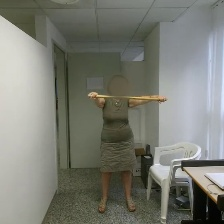

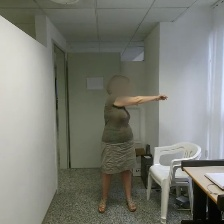

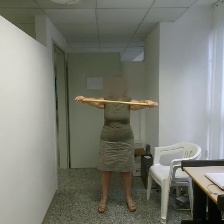

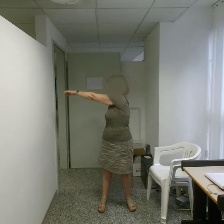

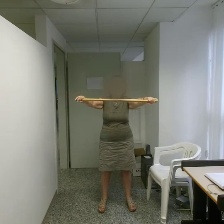

In [253]:
# print(dir_labels_gt[1][2])
def visualize_b64_from_dir(dir_path, num_frames=5):
    with open(dir_path) as f:
        base64_frames = f.readlines()
        if len(base64_frames) == 0:
            return -1
        # eval_label = base64_frames[::len(base64_frames)//4]
        img_indices = np.linspace(2, len(base64_frames)-2, num_frames, dtype=int).tolist()
        eval_label = [base64_frames[idx] for idx in img_indices]

    for img in eval_label:
        
        display(Image(data=base64.b64decode(img.encode("utf-8")), width=200))

visualize_b64_from_dir(dir_labels_gt[3][1] + "/base64.txt")

./store/P_ID15_Es1_2_s=0/base64.txt 27.666666666666668 9.0 18.666666666666668


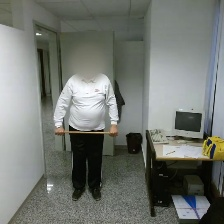

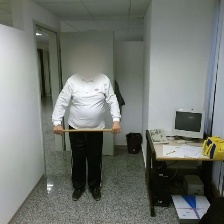

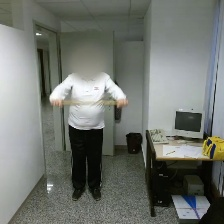

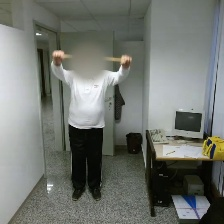

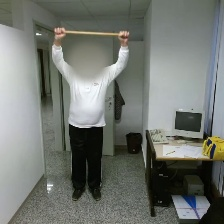

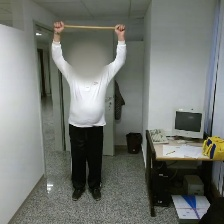

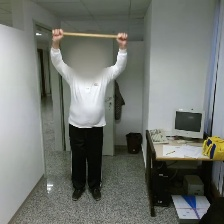

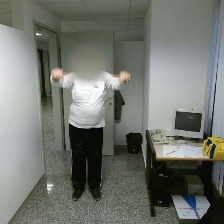

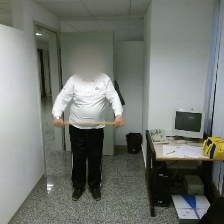

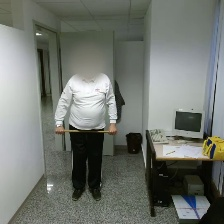

In [481]:
row = reps_df_100[(reps_df_100['score_gt'] == 0) & (reps_df_100['exe_num'] == 1)].iloc[2]
print(row['dir'], row['score_q_total'], row['score_q_po'], row['score_q_cf'])
visualize_b64_from_dir(row['dir'], num_frames=10)

Testing Inference pipeline

In [482]:
eval_b64 = get_eval_b64_from_dir(row['dir'], detail="high", num_frames=5)
if eval_b64 == -1:
    print("Empty evaluation label")
else:
    # gt_exe_b64 = get_gt_b64_from_exe_n_dict(exe_labels_gt[1], detail="low")
    exec_desc = struc_desc_by_exe[1]
    response = eval_with_oai_10q(intro_sys, intro_user, background_10q_0s, exec_desc,
                         rep_eval_10q, assess_q, eval_b64, ans_format_0s, max_tokens=300)
    # inf_score = json.loads(clean_json_string(response.choices[0].message.content))['score']
    # inf_reasoning = json.loads(clean_json_string(response.choices[0].message.content))['reasoning']

    # print(inf_score, inf_reasoning)

In [484]:
ctt = json.loads(clean_json_string(response.choices[0].message.content))
po_score = np.sum(list(ctt['answers'].values())[:3])
cf_score = np.sum(list(ctt['answers'].values())[3:])
print(po_score, cf_score, po_score + cf_score)

12 28 40


In [485]:
ctt

{'answers': {'1': 4,
  '2': 4,
  '3': 4,
  '4': 4,
  '5': 4,
  '6': 4,
  '7': 4,
  '8': 4,
  '9': 4,
  '10': 4},
 'reasoning': {'1': 'The subject achieved the primary outcomes in most frames.',
  '2': 'The exercise was carried out in a constant manner in most frames.',
  '3': 'The amplitude of the movement was complete in most frames.',
  '4': 'The posture of the head was correct in most frames.',
  '5': 'The posture of the right arm was correct in most frames.',
  '6': 'The posture of the left arm was correct in most frames.',
  '7': 'The posture of the trunk was correct in most frames.',
  '8': 'The posture of the pelvis was correct in most frames.',
  '9': 'The posture of the right leg was correct in most frames.',
  '10': 'The posture of the left leg was correct in most frames.'}}

## Batch Inference

In [ ]:
# for each exercise and each score
for exe_num in exercise_num:

    # get the ground truth base64 and execise description
    gt_exe = exe_labels_gt[exe_num]
    exec_desc = struc_desc_by_exe[exe_num]

    for sc_num in score_num:
        exe_sc_rows = reps_df_100[(reps_df_100['score_gt'] == sc_num) & (reps_df_100['exe_num'] == exe_num)]

        for idx, row in exe_sc_rows.iterrows(): # for 5 reps in each score and exercise
            eval_b64 = get_eval_b64_from_dir(row['dir'], detail="high")
            if eval_b64 is None:
                continue
            # gt_exe_b64 = get_gt_b64_from_exe_n_dict(gt_exe,  detail="high")
            response = eval_with_oai_10q(intro_sys, intro_user, background_10q_0s, exec_desc,
                                rep_eval_10q, assess_q, eval_b64, ans_format_0s, max_tokens=300)
            
            ctt = json.loads(clean_json_string(response.choices[0].message.content))
            po_score = np.sum(list(ctt['answers'].values())[:3])
            cf_score = np.sum(list(ctt['answers'].values())[3:])
            inf_reasoning = ctt['reasoning']

            reps_df_100.loc[idx, 'score_inf_total'] = po_score + cf_score
            reps_df_100.loc[idx, 'score_inf_po'] = po_score
            reps_df_100.loc[idx, 'score_inf_cf'] = cf_score
            reps_df_100.loc[idx, 'inf_reasoning'] = inf_reasoning

            print(reps_df_100.loc[idx])

In [81]:
reps_df_100

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,inf_reasoning
0,B_ID3,1,0,./store/B_ID3_Es1_0_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,NaN
1,S_ID9,1,0,./store/S_ID9_Es1_2_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,NaN
2,P_ID15,1,0,./store/P_ID15_Es1_2_s=0/base64.txt,27.666667,9.000000,18.666667,NaN,NaN,NaN,NaN
3,S_ID9,1,0,./store/S_ID9_Es1_3_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,NaN
4,S_ID4,1,0,./store/S_ID4_Es1_2_s=0/base64.txt,26.000000,6.000000,20.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,NE_ID15,5,3,./store/NE_ID15_Es5_1_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,NaN
96,NE_ID26,5,3,./store/NE_ID26_Es5_2_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,NaN
97,NE_ID19,5,3,./store/NE_ID19_Es5_2_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,NaN
98,E_ID5,5,3,./store/E_ID5_Es5_0_s=3/base64.txt,47.666667,15.000000,32.666667,NaN,NaN,NaN,NaN


In [775]:
# for each exercise and each score
for exe_num in exercise_num:

    # get the ground truth base64 and execise description
    gt_exe = exe_labels_gt[exe_num]
    exec_desc = struc_desc_by_exe[exe_num]

    for sc_num in score_num:
        exe_sc_rows = reps_df_100[(reps_df_100['score_gt'] == sc_num) & (reps_df_100['exe_num'] == exe_num)]

        for idx, row in exe_sc_rows.iterrows(): # for 5 reps in each score and exercise
            eval_b64 = get_eval_b64_from_dir(row['dir'], detail="low")
            if eval_b64 is None:
                continue
            gt_exe_b64 = get_gt_b64_from_exe_n_dict(gt_exe,  detail="low")

            response = eval_with_oai(intro_sys, intro_user, background_text, exec_desc,
                                     rep_eval, gt_exe_b64, eval_b64, ans_format, max_tokens=60)
            inf_score = json.loads(clean_json_string(response.choices[0].message.content))['score']
            inf_reasoning = json.loads(clean_json_string(response.choices[0].message.content))['reasoning']

            reps_df_100.loc[idx, 'score_inf'] = int(inf_score)
            reps_df_100.loc[idx, 'inf_reasoning'] = inf_reasoning

            print(reps_df_100.loc[idx])

pid                                                          B_ID7
exe_num                                                          5
score_gt                                                         2
dir                             ./store/B_ID7_Es5_1_s=2/base64.txt
score_inf                                                        2
inf_reasoning    The evaluated sequence demonstrates a good adh...
Name: 90, dtype: object
pid                                                          E_ID4
exe_num                                                          5
score_gt                                                         2
dir                             ./store/E_ID4_Es5_0_s=2/base64.txt
score_inf                                                        3
inf_reasoning    The evaluated sequence closely matches the gro...
Name: 91, dtype: object
pid                                                        NE_ID25
exe_num                                                          5
score_gt      

## Visualize Results

In [9]:
# reps_df_100.to_csv("./reps_df_100.csv", index=False)
import pandas as pd
reps_df_100 = pd.read_csv("./reps_df_100.csv")

In [11]:
gt_labels, inf_labels = reps_df_100['score_gt'].to_numpy().astype(np.uint8), reps_df_100['score_inf'].to_numpy().astype(np.uint8)

In [13]:
inf_labels.shape, gt_labels.shape

((100,), (100,))

In [23]:
from sklearn.metrics import confusion_matrix

cm = []
# Create confusion matrix
for i in range(1, 6):
    cm.append(np.array(confusion_matrix(gt_labels[(i-1)*20:20*i], inf_labels[(i-1)*20:20*i])))

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

plt.clf()

def plot_confusion_matrix(cm, title, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth label')
    plt.xlabel('Predicted label, GPT-4o, detail="low"')
    plt.tight_layout()


confusion_matrix_tot = np.array(
[[ 7,  7, 11,  0],
 [ 4, 11,  8,  2],
 [ 2,  2, 15,  6],
 [ 2,  0, 10, 13],])

class_names = ['0=Bad', '1=Good', '2=Very Good', '3=Perfect']


plt.figure(figsize=(12, 12))

# Plotting the first subfigure
plt.subplot(3, 2, 1)
plot_confusion_matrix(cm[0], '1-Shot Confusion Matrix for Exercise 1, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the second subfigure
plt.subplot(3, 2, 2)
plot_confusion_matrix(cm[1], '1-Shot Confusion Matrix for Exercise 2, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the third subfigure
plt.subplot(3, 2, 3)
plot_confusion_matrix(cm[2], '1-Shot Confusion Matrix for Exercise 3, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the fourth subfigure
plt.subplot(3, 2, 4)
plot_confusion_matrix(cm[3], '1-Shot Confusion Matrix for Exercise 4, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the fourth subfigure
plt.subplot(3, 2, 5)
plot_confusion_matrix(cm[4], '1-Shot Confusion Matrix for Exercise 5, \n No Questionnaire', class_names)

plt.tight_layout()
plt.savefig("confusion_matrix_5cls.png")

# Plotting the fourth subfigure
plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(confusion_matrix_tot, '1-Shot Confusion Matrix for \n 5 Exercises Merged (100 samples), \n No Questionnaire', class_names)

plt.savefig("cm_total.png")
# plt.show()

In [270]:
response.usage

CompletionUsage(completion_tokens=39, prompt_tokens=3319, total_tokens=3358)

## Stateful Queries with GPT-4o Assistant API

In [ ]:
from openai import OpenAI
client = OpenAI()
  
assistant = client.beta.assistants.create(
  name="Math Tutor",
  instructions="You are a personal math tutor. Write and run code to answer math questions.",
  tools=[{"type": "code_interpreter"}],
  model="gpt-4o",
)

In [ ]:
thread = client.beta.threads.create()

In [ ]:
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="I need to solve the equation `3x + 11 = 14`. Can you help me?"
)

In [ ]:
run = client.beta.threads.runs.create_and_poll(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="Please address the user as Jane Doe. The user has a premium account."
)

In [ ]:
if run.status == 'completed': 
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
else:
  print(run.status)